# Test case 04 benchmark DLFT vs WR


## Test case number 01 

![TC_04](./_images/TC_04.PNG "TC_04")



| $m_{1}$ | $m_{2}$ | $c$ | $k$| $k_{12}$| $\mu N$| $F_{ext}$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| $1$ | $2e-02$ | $1e-02$ | $1$ | $1$ | $0.15$ | $1$ |

In [1]:
# make generic imports 
import pyHarm
import numpy as np
from HelperFunctions import prep_fig, export_sol, get_frf, create_directory_relative, modify_input_dict, build_style, mid
import copy 
NAME_STUDY = "TC_04"
create_directory_relative(NAME_STUDY)

from pyHarm.BaseUtilFuncs import pyHarm_plugin
from CustomDLFTFriction import DLFTFriction
pyHarm_plugin(DLFTFriction)


Directory 'TC_04' created or already exists.


In [2]:
# Brut data from drawings
m1, m2 = 1., 1.
k, k_12 = 1e0, 1e0
c = 1e-2
mu, N0 = 0.15, 1.0
Fext = 1.
epsilon_dlft = 1e3
## let's build the matrices 
M = np.diag(np.array(
    [m1,m2]
))
K = np.array(
    [
        [k,-k_12],
        [-k_12,k+k_12]
    ]
)
C = np.array(
    [
        [c,0.],
        [0.,c]
    ]
)
G = 0*C # No gyroscopic matrice

# Let's construct everything for the system to be built : 
sub_dict = dict(
    type='substructure',
    ndofs=1,
    matrix = dict(
        M = M,
        C = C,
        G = G,
        K = K
    )
)
loading = dict(
        type='CosinusForcing',
        connect=dict(sub=[0]),
        dirs=[0],
        amp = Fext
)
friction= dict(
        type='DLFTFriction',
        connect=dict(sub=[0], INTERNAL=[1]),
        dirs=[0],
        mu = mu,
        N0 = N0,
        eps = epsilon_dlft,
        jac='jax'
    )

system_dict = dict(
    type='Base',
    nh = 1,
    nti = 2**(12),
    adim = dict(status=False, lc=1.0, wc=1.0)
)

basic_system_dict = dict(
    system = system_dict,
    substructures = dict(sub = sub_dict),
    connectors=dict(
        loading = loading,
        friction = friction
    )
)
from pyHarm.Elements.NodeToNodeElements.DLFTElements import DLFTUniGap
from pyHarm.Systems.FactorySystem import generateSystem
sys_test = generateSystem(system_dict['type'], basic_system_dict)
print(f"System is composed of {len(sys_test.LE)} connectors that are : ")
[print(f"- {e.__repr__()}") for e in sys_test.LE]
sys_test.expl_dofs


[   INFO   ] -- 15:17:53 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    6     |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    3     |
                         |     Kinematics     |    0     |
                         |     Harmonics      |    1     |
                         |     Time steps     |   4096   |



System is composed of 3 connectors that are : 
- sub[Substructure]
- loading[CosinusForcing]
- friction[DLFTFriction]


,sub,harm,cs,node_num,dof_num,PoM,NL,KC
0,sub,0,c,0,0,p,1,0
1,sub,0,c,1,0,p,1,0
2,sub,1,c,0,0,p,1,0
3,sub,1,c,1,0,p,1,0
4,sub,1,s,0,0,p,1,0
5,sub,1,s,1,0,p,1,0


In [3]:
# Build up the analysis
## analysis parameters

PULS_INF = 1e-03
PULS_SUP = 2.5
NB_SOL_MINI = 1E3
NB_FAIL_AUTHORIZED = 12
DS_MAX = (PULS_SUP - PULS_INF) / NB_SOL_MINI
DS_MIN = DS_MAX * 2**(-NB_FAIL_AUTHORIZED)
VERBOSE = True

## modification of the system
NH = 1
NTI = 2**(12)
WC = 1.0
LC = 1e0
ADIM = True

## analysis dico : 
frf_dict = dict(
    study='frf',
    puls_inf = PULS_INF,
    puls_sup = PULS_SUP,
    ds_max = DS_MAX,
    ds_min = DS_MIN,
    ds0 = DS_MAX,
    verbose=VERBOSE,
    sign_ds=+1,
    predictor_options=dict(norm="om")
)

In [4]:
# Run the basic linear solution first
input_dict = dict(
    analysis = dict(
        FRF = frf_dict
    ),
    system = system_dict,
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
    )
)
L = pyHarm.Maestro(input_dict)
L.operate()


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 15:17:53 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    6     |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    2     |
  

In [5]:
import pyHarm.Systems
import pyHarm.Systems.ABCSystem

# This is provided by CHARLEUX as best EPSILON selection for the DLFT method !
# see : Numerical and Experimental Study of Friction Damping in Blade Attachments of Rotating Bladed Disks, (2006), International Journal of Rotating Machinery
def spectral_radius_dynamicMat(sys:pyHarm.Systems.ABCSystem, om: float, _nh:int|list[int]=3) :
    if isinstance(_nh,list):
        nh = max(_nh)
    else : nh = _nh
    xx0 = np.zeros(sys.ndofs)
    x0 = np.concatenate([xx0, np.array([om])])
    Z = sys._jacobian(sys.LE_linear, x0)[0]
    n_block = int((Z.shape[0]-1)/2.)
    Z00 = Z[0:n_block,0:n_block]
    Z11 = Z[n_block:n_block*3,n_block:n_block*3]
    Zhh = np.kron(np.eye(nh), Z11)
    Zextended = np.block(
        [
            [Z00,np.zeros((Z00.shape[0], Zhh.shape[1]))],
            [np.zeros((Zhh.shape[0], Z00.shape[1])),Zhh]
        ]
    )
    return np.max(np.abs(np.linalg.eig(Zextended)[0]))

spectral_radius_dynamicMat(L.system, 9e-1, _nh=3)

np.float64(2.618033988749895)

In [6]:

from pyHarm.Predictors.PredictorTangent import PredictorTangent
from pyHarm.Solver import FirstSolution, SystemSolution
from pyHarm.BaseUtilFuncs import getCustomOptionDictionary
import numpy as np
import scipy.linalg as spl

class PredictorSecant(PredictorTangent):
    """Define the Secant predictor. From the last two solution points, generates the adequate direction. When only one solution point is available, makes use of the tangent predictor.
    """
    predictor_name = "Secant Predictor"
    """str: keyword that is used to call the creation of this class in the system factory."""
    factory_keyword : str = "secant"

    def predict_usingtan(self, sollist:list, ds:float, k_imposed=None) -> tuple[np.ndarray,SystemSolution,float]:
        """Predicts the next starting point using the tangent.

        Args:
            sollist (list[SystemSolution]): list of SystemSolution already solved during the analysis.
            ds (float): step size for the prediction.
            k_imposed (None | int): if not None, uses the k_imposed as the index of the last solution pointer.

        Returns:
            np.ndarray: next predicted starting point.
            SystemSolution: last accepted point in the list of solutions.
            float: sign of the prediction used (-1 | 1)
        """
        return super().predict(sollist,ds,k_imposed=None)

    def predict(self, sollist:list, ds:float, k_imposed=None) -> tuple[np.ndarray,SystemSolution,float]:
        """Predicts the next starting point using secant prediction.

        Args:
            sollist (list[SystemSolution]): list of SystemSolution already solved during the analysis.
            ds (float): step size for the prediction.
            k_imposed (None | int): if not None, uses the k_imposed as the index of the last solution pointer.

        Returns:
            np.ndarray: next predicted starting point.
            SystemSolution: last accepted point in the list of solutions.
            float: sign of the prediction used (-1 | 1)
        """
        ### Get pointer to solution, Jacobian in full mode, and bifurcation detection
        lstpt = self.getPointerToSolution(sollist,k_imposed) # get pointer
        lstpt.getJacobian("full") # get J_f
        self.bifurcation_detect(lstpt) # get pointer
        if isinstance(lstpt,FirstSolution) : 
            xpred,lstpt,self.sign_ds = self.predict_usingtan(sollist,ds,k_imposed=None)
        else : 
            dir = (lstpt.x - lstpt.precedent_solution.x)/np.linalg.norm(lstpt.x - lstpt.precedent_solution.x)
            dir = self.norm_dir(dir) * np.sign(dir[-1])
            xpred = lstpt.x + dir * ds
            ## write some stuff in the solution
            lstpt.dir = dir
            lstpt.x_pred = xpred
        return xpred,lstpt,self.sign_ds

pyHarm_plugin(PredictorSecant)

In [17]:
def mid(*args):
    return modify_input_dict(*args)
# Run the basic nonlinear solution then
## modifications for frf parameters
modif_frf = dict()
## modifications for system parameters
NH_NL = 3 + 60-3
NH_NL = [i for i in range(1,NH_NL,2)]
NTI_NL = 32 # using DLFT connector increasing NTI cost a lot of computing time ! This might be not the case for WR
# EPSILON_DLFT = 1e6
spectral_radius_for_dlft = spectral_radius_dynamicMat(L.system, 1.132e0, NH_NL)
EPSILON_DLFT = spectral_radius_for_dlft
# EPSILON_DLFT = 3e0
print(f"Using spectral radius as advised by Charleux is providing eps={EPSILON_DLFT:.3E}")
SIGN_DS = -1

input_dict_NL = dict(
    analysis = dict(
        FRF = mid(
            frf_dict,
            dict(
                verbose=True,
                sign_ds = SIGN_DS,
                predictor="tangent",
                predictor_options=dict(norm="om"),
                reductors = [dict(type='NLdofs')],
                solver="NewtonRaphson",
                solver_options=dict(
                    end_status_accepted=[1,4,5],
                    residual_tolerance=2e-1
                ),
                # dict(type='globalHarmonic', err_admissible=1e-3) pour avoir la conservation d'harmoniques possible de faire 
                # h_always_kept = np.ararnge(1,NH+1,2) pour avoir que les harmoniques impaires voir documentation
            )
        )
    ),
    system = mid(system_dict, dict(nh=NH_NL, nti=NTI_NL, adim=dict(status=True, lc=1.0, wc =1.130))),
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
        friction = mid(
            friction,
            dict(eps=EPSILON_DLFT),
        )
    )
)
NL = pyHarm.Maestro(input_dict_NL)
NL.operate()


from pyHarm.Elements.NodeToNodeElements.DLFTElements import DLFTFriction
from pyHarm.NonLinearSolver.ScipyRoot import Solver_ScipyRoot


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 15:20:36 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |   120    |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    3     |
  

[   INFO   ] -- 15:20:36 --      Converged       - om = 2.212E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.210E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.207E+00 rad/s


Using spectral radius as advised by Charleux is providing eps=2.618E+00


[   INFO   ] -- 15:20:36 --      Converged       - om = 2.205E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.202E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.200E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.197E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.195E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.192E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.190E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.187E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.185E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.182E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.180E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.177E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.175E+00 rad/s
[   INFO   ] -- 15:20:36 --      Converged       - om = 2.172E+0

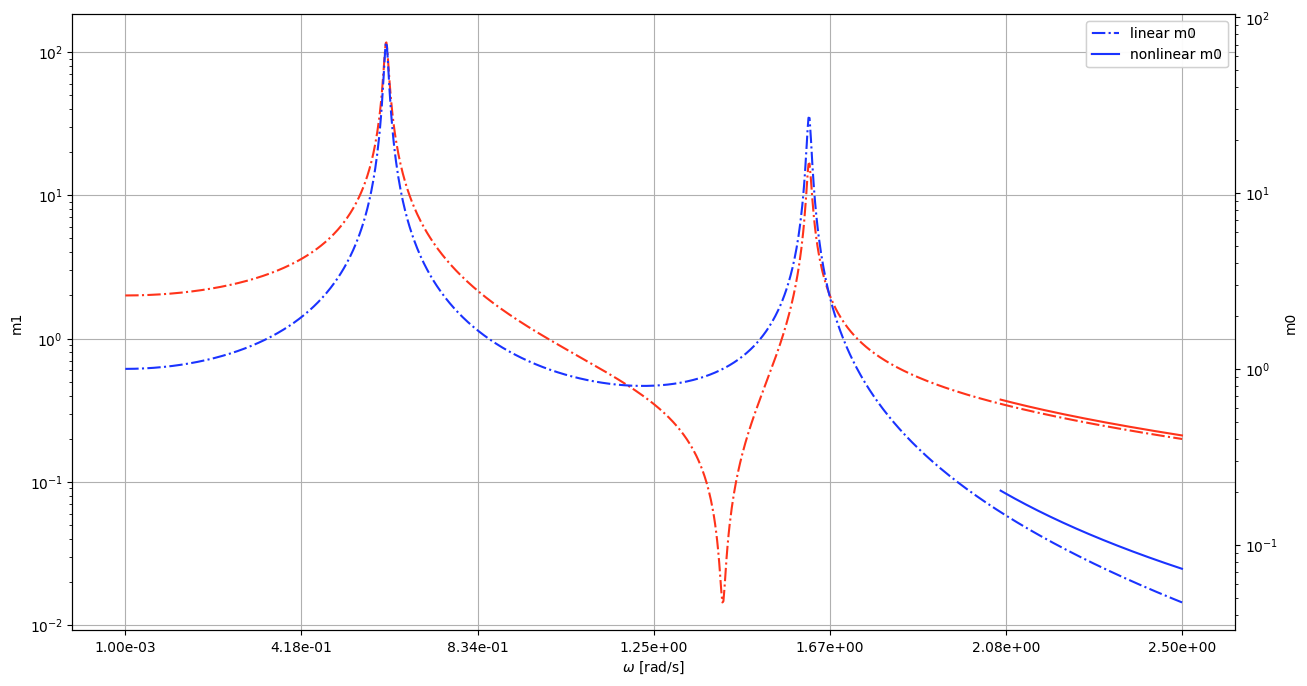

In [16]:
Lres_m1 = get_frf(L, sub='sub', node=0)
Lres_m0 = get_frf(L, sub='sub', node=1) # The inversion IS normal here
NLres_m1 = get_frf(NL, sub='sub', node=0)
NLres_m0 = get_frf(NL, sub='sub', node=1) # The inversion IS normal here

Lplt = dict(linestyle='-.', label='linear')
NLplt = dict(linestyle='-', label='nonlinear')
m1plt = dict(color=(1.0, 0.2, 0.1), label='m1')
m0plt = dict(color=(0.1, 0.2, 1.0), label='m0')
thresholdplt = dict(linestyle='--', linewidth=2, color=(0.0, 0.0, 0.0), label='gap threshold')

fig,ax = prep_fig(fp=np.linspace(PULS_INF, PULS_SUP,7))
ax_m0 = ax.twinx()
ax.plot(*Lres_m1, **build_style(Lplt, m1plt))
ax_m0.plot(*Lres_m0, **build_style(Lplt, m0plt))
ax.plot(*NLres_m1, **build_style(NLplt, m1plt))
ax_m0.plot(*NLres_m0, **build_style(NLplt, m0plt))
ax.legend()
ax_m0.legend()
ax.set_ylabel('m1')
ax_m0.set_ylabel('m0')
ax.set_xlabel('$\omega$ [rad/s]')
ax.set_yscale('log')
ax_m0.set_yscale('log')

In [45]:



export_sol(L, path=f"./{NAME_STUDY}", prefix=f"linear")
export_sol(NL, path=f"./{NAME_STUDY}", prefix=f"nonlinear")

In [60]:
SNA = [sol for sol in NL.nls['FRF'].SolList if not sol.flag_accepted]

In [61]:
np.linalg.norm(SNA[-1].R_solver)

np.float64(0.005349588317845632)

In [63]:
SNA[-1].status_solver

4

In [ ]:
from pyHarm.NonLinearSolver.ScipyRoot